-----
# Implementing a GPT model from Scratch to Generate Text
-----

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024, # No of tokens porcessed at once
    "emb_dim": 768, # dimensionality of the token embeddings also referred as d_in previously
    "n_heads": 12, # No of attn heads
    "n_layers": 12, # No of layers, Number of transformer block layer
    "drop_rate": 0.1,
    "qkv_bias": False

}

# GPT Architecture PART 1 : dummy GPT model class



In [2]:
import torch
import torch.nn as nn

In [3]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):  # in_idx is the input which it takes
        batch_size, seq_len = in_idx.shape  # Extract the batch size (number of sequences) and sequence length (number of tokens per sequence).
        tok_embdd = self.tok_emb(in_idx)  # Compute token embeddings for the input indices using the token embedding layer.
        pos_embdd = self.pos_emb(torch.arange(seq_len))  # Generate positional embeddings for each position in the sequence (0 to seq_len - 1).
        x = tok_embdd + pos_embdd  # Combine token embeddings and positional embeddings element-wise.
        x = self.drop_emb(x)  # Apply dropout to the combined embeddings for regularization.
        x = self.trf_blocks(x)  # Pass the embeddings through the transformer blocks (e.g., multi-head attention and feed-forward layers).
        x = self.final_norm(x)  # Apply layer normalization to the output of the transformer blocks.
        logits = self.out_head(x)  # Compute the final output logits using the output head (e.g., a linear layer).
        return logits  # Return the logits, which represent the model's predictions.


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

### prepare the input data and initialize a new GPT model 

### STEP 1: TOKENIZATION

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### Instance of DummyGPT Model

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has two rows corresponding to the two text samples. Each text sample consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer's vocabulary.

The embedding has 50,257 dimensions because each of these dimensions refers to a unique token in the vocabulary. At the end of this chapter, when we implement the postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs, which we can then decode into words.

Now that we have taken a top-down look at the GPT architecture and its in- and outputs, we will code the individual placeholders in the upcoming sections, starting with the real layer normalization class that will replace the DummyLayerNorm in the previous code.

# GPT ARCHITECTURE PART 2: LAYER NORMALIZATION

We will start with a simple example

In [6]:
# Create a random batch of input data with shape (batch_size, feature_dim)
# feature_dim is the number of features(size of the vector) per token in the input data
# Here, batch_size = 2 (2 examples) and feature_dim = 5 (5 features per example)
batch_example = torch.randn(2, 5) 

# Define a simple neural network layer using nn.Sequential
# nn.Sequential allows us to stack multiple layers together in sequence
layer = nn.Sequential(
    nn.Linear(5, 6),  # A linear (fully connected) layer with input size 5 and output size 6
    nn.ReLU()         # A ReLU (Rectified Linear Unit) activation function
)

# Pass the batch of input data through the layer
out = layer(batch_example)

# Print the output
print(out)

tensor([[0.0000, 0.0000, 0.0000, 0.6313, 0.7296, 0.2337],
        [0.0000, 0.0000, 0.0000, 0.4068, 0.8312, 0.2266]],
       grad_fn=<ReluBackward0>)


In [7]:
mean = out.mean(dim=-1, keepdim=True) # Compute the mean of the output tensor along the last dimension, keepdim=True ensures the output has the same number of dimensions as the input
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean) # Print the mean
print("Variance:\n", var) # Print the variance

Mean:
 tensor([[0.2658],
        [0.2441]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.1123],
        [0.1100]], grad_fn=<VarBackward0>)


Next, let us apply layer normalization to the layer outputs we obtained earlier. The operation consists of subtracting the mean and dividing by the square root of the variance (also known as standard deviation):

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[-0.7930, -0.7930, -0.7930,  1.0905,  1.3839, -0.0955],
        [-0.7358, -0.7358, -0.7358,  0.4905,  1.7698, -0.0528]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[ 9.9341e-08],
        [-4.4703e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


Note that the value 2.9802e-08 in the output tensor is the scientific notation for 2.9802 × 10-8, which is 0.0000000298 in decimal form. This value is very close to 0, but it is not exactly 0 due to small numerical errors that can accumulate because of the finite precision with which computers represent numbers.


To improve readability, we can also turn off the scientific notation when printing tensor values by setting sci_mode to False:

In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim): 
        super().__init__() # Call the constructor of the nn.Module class
        self.eps = 1e-5 # Define a small value epsilon to avoid division by zero
        self.scale = nn.Parameter(torch.ones(emb_dim)) # Create a learnable parameter tensor for the scale factor with dimension emb_dim
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # Create a learnable parameter tensor for the shift factor with dimension emb_dim

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # Compute the mean of the input tensor along the last dimension
        var = x.var(dim=-1, keepdim=True, unbiased=False) # Compute the variance of the input tensor along the last dimension
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # Normalize the input tensor by subtracting the mean and dividing by the square root of the variance
        return self.scale * norm_x + self.shift # Apply the scale and shift parameters to the normalized tensor and return the result   

The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task.

This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.

In [11]:
# Let's now try the LayerNorm module in practice and apply it to the batch input:

ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


As we can see based on the results, the layer normalization code works as expected and normalizes the values of each of the two inputs such that they have a mean of 0 and a variance of 1:

# GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION

In [12]:
# Let's implement the GELU activation function approximation used by GPT-2:

class GELU(nn.Module): # Define a new class GELU that inherits from nn.Module
    def __init__(self):
        super().__init__()

    def forward(self, x): # This code is basically the Mathematical formula to calculate GELU
        return 0.5 * x * (1 + torch.tanh( # Compute the GELU activation function
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * # Define the scaling factor for the approximation of the Gaussian error function (erf)
            (x + 0.044715 * torch.pow(x, 3)) # Compute the polynomial approximation for the GELU function
        )) 

#### To get an idea of what this GELU function looks like and how it compares to the ReLU function, let's plot these functions side by side:

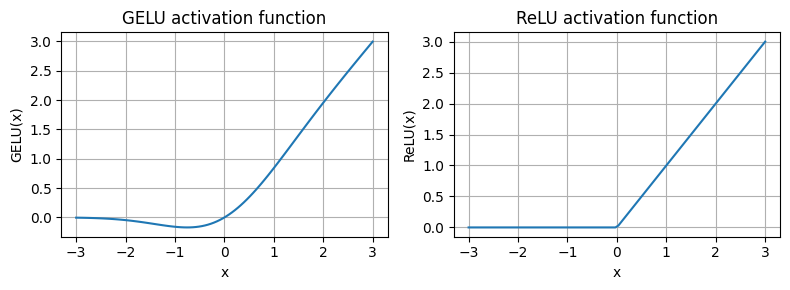

In [13]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU() # Create instances of the GELU and ReLU activation functions

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


As we can see in the resulting plot, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero.

GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values.

The smoothness of GELU, as shown in the above figure, can lead to better optimization properties during training, as it allows for more nuanced adjustments to the model's parameters.

In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures.

Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output for negative values.

This characteristic means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs.

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(  # Define a feed-forward neural network with two linear layers and a GELU activation function
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # A linear layer with input size emb_dim and output size 4 * emb_dim
            GELU(),                                        # Apply the GELU activation function
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # A linear layer with input size 4 * emb_dim and output size emb_dim
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
print(GPT_CONFIG_124M["emb_dim"])


768


In [16]:
# Let's use the GELU function to implement the small neural network module, FeedForward, that we will be using in the LLM's transformer block later:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape) 

torch.Size([2, 3, 768])


The FeedForward module we implemented in this section plays a crucial role in enhancing the model's ability to learn from and generalize the data.

Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher-dimensional space through the first linear layer.

This expansion is followed by a non-linear GELU activation, and then a contraction back to the original dimension with the second linear transformation.

Such a design allows for the exploration of a richer representation space.

Moreover, the uniformity in input and output dimensions simplifies the architecture by enabling the stacking of multiple layers, as we will do later, without the need to adjust dimensions between them, thus making the model more scalable.

# GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS

In [17]:
# Let us see how we can add shortcut connections to the forward method:

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output # Add the output of the current layer to the input
            else:
                x = layer_output # If shortcut cannot be applied, just update x to the output of the current layer
        return x

The code implements a deep neural network with 5 layers, each consisting of a Linear layer and a GELU activation function.

In the forward pass, we iteratively pass the input through the layers and optionally add the shortcut connections if the self.use_shortcut attribute is set to True.

In [18]:
# Let's use this code to first initialize a neural network without shortcut connections. 
# Here, each layer will be initialized such that it accepts an example with 3 input values and returns 3 output values. The last layer returns a single output value:

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False # Set use_shortcut to False
)

Next, we implement a function that computes the gradients in the the model's backward pass:

In [19]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss() # Mean Squared Error Loss function 
    loss = loss(output, target) 
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In the preceding code, we specify a loss function that computes how close the model output and a user-specified target (here, for simplicity, the value 0) are.

Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model.

We can iterate through the weight parameters via model.named_parameters().

Suppose we have a 3×3 weight parameter matrix for a given layer.

In that case, this layer will have 3×3 gradient values, and we print the mean absolute gradient of these 3×3 gradient values to obtain a single gradient value per layer to compare the gradients between layers more easily.

In short, the .backward() method is a convenient method in PyTorch that computes loss gradients, which are required during model training, without implementing the math for the gradient calculation ourselves, thereby making working with deep neural networks much more accessible.

Let's now use the print_gradients function and apply it to the model without skip connections:

In [20]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


As we can see based on the output of the print_gradients function, the gradients become smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which is a phenomenon called the vanishing gradient problem.
Let's now instantiate a model with skip connections and see how it compares:

In [21]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True # Set use_shortcut to True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.3289699852466583
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


# GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

### Multihead Block   

In [22]:
# First we will define the MultiHeadAttention module, which will be used in the transformer block:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

### Transformer Block

In [23]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024, # No of tokens porcessed at once
    "emb_dim": 768, # dimensionality of the token embeddings also referred as d_in previously
    "n_heads": 12, # No of attn heads
    "n_layers": 12, # No of layers, Number of transformer block layer
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Whether to use bias in the query, key, and value projections
}

In [24]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention( 
            d_in=cfg["emb_dim"], # d_in is the input dimension
            d_out=cfg["emb_dim"],  # d_out is the output dimension
            context_length=cfg["context_length"], # context_length is the maximum sequence length
            num_heads=cfg["n_heads"], # n_heads is the number of attention heads
            dropout=cfg["drop_rate"], # drop_rate is the dropout rate
            qkv_bias=cfg["qkv_bias"]) 
        self.ff = FeedForward(cfg) 
        self.norm1 = LayerNorm(cfg["emb_dim"]) # Layer normalization for the attention block
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"]) 

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x) 
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x) 
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x) 
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

The given code defines a TransformerBlock class in PyTorch that includes a multi-head attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward), both configured based on a provided configuration dictionary (cfg), such as GPT_CONFIG_124M

Layer normalization (LayerNorm) is applied before each of these two components, and dropout is applied after them to regularize the model and prevent overfitting.

This is also known as Pre-LayerNorm.

Older architectures, such as the original transformer model, applied layer normalization after the self-attention and feed-forward networks instead, known as Post-LayerNorm, which often leads to worse training dynamics.

The class also implements the forward pass, where each component is followed by a shortcut connection that adds the input of the block to its output. This critical feature helps gradients flow through the network during training and improves the learning of deep models

Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer block and feed it some sample data

In [25]:
# Create sample input of shape [batch_size, num_tokens, emb_dim]

torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [26]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024, # No of tokens porcessed at once
    "emb_dim": 768, # dimensionality of the token embeddings also referred as d_in previously
    "n_heads": 12, # No of attn heads
    "n_layers": 12, # No of layers, Number of transformer block layer
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Whether to use bias in the query, key, and value projections
}

In [27]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) # initialize token embedding layer
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) # initialize positional embedding layer
        self.drop_emb = nn.Dropout(cfg["drop_rate"]) # Apply dropout to the embeddings
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]) # initialize transformer blocks, 12 transofmer blocks in our case
        
        self.final_norm = LayerNorm(cfg["emb_dim"]) # initialize layer normalization
        self.out_head = nn.Linear(  
            cfg["emb_dim"], cfg["vocab_size"], bias=False # initialize output head 
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape # Extract the batch size and sequence length from the input tensor
        tok_embeds = self.tok_emb(in_idx) # Step 1 : Compute token embeddings for the input indices
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # Step 2 : Generate positional embeddings for each position in the sequence
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size] # Step 3 : Combine token embeddings and positional embeddings
        x = self.drop_emb(x) # Step 4 : Apply dropout to the combined embeddings
        x = self.trf_blocks(x) # Step 5 : Pass the embeddings through the transformer blocks
        x = self.final_norm(x) # Step 6 : Apply layer normalization to the output of the transformer blocks
        logits = self.out_head(x) # Step 7 : Compute the final output logits using the output head
        return logits # Step 8 : Return the logits, which represent the model's predictions

In [28]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [29]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [31]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [32]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


# GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS

Step 1: idx is a (batch, n_tokens) array of indices in the current context

Step 2: Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the context size is 10 then only the last 5 tokens are used as context

Step 3: Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

Step 4: probas has shape (batch, vocab_size)

Step 5: idx_next has shape (batch, 1)

Step 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

In [33]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In the preceeding code, the generate_text_simple function, we use a softmax function to convert the logits into a probability distribution from which we identify the position with the highest value via torch.argmax.

The softmax function is monotonic, meaning it preserves the order of its inputs when transformed into outputs.

So, in practice, the softmax step is redundant since the position with the highest score in the softmax output tensor is the same position in the logit tensor.

In other words, we could apply the torch.argmax function to the logits tensor directly and get identical results.

However, we coded the conversion to illustrate the full process of transforming logits to probabilities, which can add additional intuition, such as that the model generates the most likely next token, which is known as greedy decoding.

In the next chapter, when we will implement the GPT training code, we will also introduce additional sampling techniques where we modify the softmax outputs such that the model doesn't always select the most likely token, which introduces variability and creativity in the generated text.

Let's now try out the generate_text_simple function with the "Hello, I am" context as model input
First, we encode the input context into token IDs:

In [34]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context) # Encode the starting context using the tokenizer
print("encoded:", encoded) # Print the encoded tokens
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A # Convert the encoded tokens to a tensor and add a batch dimension 
print("encoded_tensor.shape:", encoded_tensor.shape) # Print the shape of the tensor

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Next, we put the model into .eval() mode, which disables random components like dropout, which are only used during training, and use the generate_text_simple function on the encoded input tensor:
We disable dropout since we are not training the model

In [35]:
model.eval() #A # Set the model to evaluation mode (no training)
out = generate_text_simple( # Generate text using the model
model=model, # Pass the model 
idx=encoded_tensor, 
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [36]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


-----
# EVALUATING GENERATIVE TEXT MODELS
-----

## GPT Model class we coded earlier

In [37]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Using GPT to generate text

In [38]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

Next, we use the generate_text_simple function from the previous chapter to generate text.

In addition, we define two convenience functions, text_to_token_ids and token_ids_to_text, for converting between token and text representations that we use throughout this chapter

In [39]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren



# Pre Training LLMs


Suppose we have an inputs tensor containing the token IDs for 2 training examples (rows)

Corresponding to the inputs, the targets contain the desired token IDs that we want the model to generate

Notice that the targets are the inputs shifted by 1 position, as explained in chapter 2 when we implemented the data loader

In [40]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary

Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

In [41]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


As discussed in the previous chapter, we can apply the argmax function to convert the probability scores into predicted token IDs.

The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token.

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:

In [42]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens.

That's because the model wasn't trained yet.

To train the model, we need to know how far it is away from the correct predictions (targets)

In [43]:
print(f"Targets batch 1: {  (targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1: (tensor([3626, 6100,  345]), <Encoding 'gpt2'>)
Outputs batch 1:  Armed heNetflix


# Cross-entropy loss


The token probabilities corresponding to the target indices are as follows:

In [44]:
# Initialize text index to 0
# This index corresponds to the first text sequence in the batch
text_idx = 0

# Extract the predicted probabilities for the target tokens in the first text sequence
# probas: A tensor of shape (batch_size, sequence_length, vocab_size) containing predicted probabilities
# text_idx: Index of the text sequence in the batch (0 for the first sequence)
# [0, 1, 2]: Indices of the positions in the sequence (e.g., first three tokens)
# targets[text_idx]: The true token IDs for the text sequence (ground truth)
# target_probas_1: A tensor containing the predicted probabilities for the true tokens at positions 0, 1, and 2
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]

# Print the predicted probabilities for the target tokens in the first text sequence
print("Text 1:", target_probas_1)

# Update text index to 1
# This index corresponds to the second text sequence in the batch
text_idx = 1

# Extract the predicted probabilities for the target tokens in the second text sequence
# Similar to the first text sequence, but now for the second sequence in the batch
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]

# Print the predicted probabilities for the target tokens in the second text sequence
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


We want to maximize all these values, bringing them close to a probability of 1.

In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.

In [45]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [46]:
# Next, we compute the average log probability:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.

The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

In [47]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


PyTorch already implements a cross_entropy function that carries out the previous steps

Before we apply the cross_entropy function, let's check the shape of the logits and targets

In [48]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

In [49]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.

The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

In [50]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


# Perplexity

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

In [51]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.

Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

## Calculating the training and validation set losses

In [52]:
import os
import urllib.request

file_path = "autoware.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [53]:
# A quick check that the text loaded ok by printing the first and last 100 words
print(text_data[:99])


The Project Gutenberg EBook of The Bhagavad-Gita, by Anonymous

This eBook is for the use of anyon


In [54]:
# Last 100 characters
print(text_data[-99:])

p produce our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.





In [55]:
# Now we tokenize the text data using the GPT-2 tokenizer
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 137483
Tokens: 38552


## Implementing the DataLoader:

In [56]:
from torch.utils.data import Dataset, DataLoader
import torch
import tiktoken  # For tokenization

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        """
        Custom PyTorch Dataset for preparing input-target pairs for GPT-style models.
        
        Args:
            txt (str): The input text data.
            tokenizer: Tokenizer to convert text into token IDs.
            max_length (int): Maximum length of each input sequence.
            stride (int): Step size for the sliding window to create overlapping sequences.
        """
        self.input_ids = []  # Stores input sequences
        self.target_ids = []  # Stores target sequences (shifted by 1 from input)

        # Tokenize the entire text into token IDs
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the tokenized text into overlapping sequences
        for i in range(0, len(token_ids) - max_length, stride):
            # Extract input sequence of length `max_length`
            input_chunk = token_ids[i:i + max_length]
            # Extract target sequence (shifted by 1 from input)
            target_chunk = token_ids[i + 1: i + max_length + 1]
            
            # Convert lists to PyTorch tensors and store them
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        """
        Returns the total number of input-target pairs in the dataset.
        """
        return len(self.input_ids)

    def __getitem__(self, idx):
        """
        Returns the input-target pair at the specified index.
        
        Args:
            idx (int): Index of the input-target pair to retrieve.
        
        Returns:
            tuple: (input_ids, target_ids) as PyTorch tensors.
        """
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    """
    Creates a PyTorch DataLoader for the GPTDatasetV1.
    
    Args:
        txt (str): The input text data.
        batch_size (int): Number of sequences per batch.
        max_length (int): Maximum length of each input sequence.
        stride (int): Step size for the sliding window to create overlapping sequences.
        shuffle (bool): Whether to shuffle the dataset.
        drop_last (bool): Whether to drop the last incomplete batch.
        num_workers (int): Number of subprocesses to use for data loading.
    
    Returns:
        DataLoader: PyTorch DataLoader for the GPTDatasetV1.
    """
    # Initialize the tokenizer (using GPT-2 tokenizer from tiktoken)
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create the dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create the DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,  # Number of sequences per batch
        shuffle=shuffle,  # Shuffle the dataset
        drop_last=drop_last,  # Drop the last incomplete batch
        num_workers=num_workers  # Number of subprocesses for data loading
    )

    return dataloader

In [57]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [58]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [59]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [60]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [61]:
# An optional check that the data was loaded correctly:

train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 34816
Validation tokens: 3072
All tokens: 37888


In [62]:
# GPT Class that we had already coded

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader.

In [63]:
import torch

def calc_loss_batch(input_batch, target_batch, model, device):
    """
    Calculate the loss for a single batch of input-target pairs.
    
    Args:
        input_batch (torch.Tensor): Input batch of token IDs (shape: [batch_size, seq_len]).
        target_batch (torch.Tensor): Target batch of token IDs (shape: [batch_size, seq_len]).
        model (torch.nn.Module): The model to evaluate.
        device (torch.device): The device (e.g., "cpu" or "cuda") where the computation will be performed.
    
    Returns:
        torch.Tensor: The computed loss for the batch.
    """
    # Move input and target batches to the specified device (e.g., GPU)
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
    # Forward pass: compute logits (model predictions)
    logits = model(input_batch)
    
    # Compute the cross-entropy loss between the logits and target batch
    # Flatten the logits and targets to compute loss over all tokens in the batch
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    Calculate the average loss over a DataLoader.
    
    Args:
        data_loader (torch.utils.data.DataLoader): DataLoader providing input-target batches.
        model (torch.nn.Module): The model to evaluate.
        device (torch.device): The device (e.g., "cpu" or "cuda") where the computation will be performed.
        num_batches (int, optional): Number of batches to evaluate. If None, evaluate all batches.
    
    Returns:
        float: The average loss over the specified number of batches.
    """
    total_loss = 0.  # Accumulator for total loss
    
    # Handle edge case: if the DataLoader is empty, return NaN
    if len(data_loader) == 0:
        return float("nan")
    
    # If num_batches is not specified, evaluate all batches in the DataLoader
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # If num_batches is specified, ensure it does not exceed the total number of batches
        num_batches = min(num_batches, len(data_loader))
    
    # Iterate through the DataLoader
    for i, (input_batch, target_batch) in enumerate(data_loader):
        # Stop after processing the specified number of batches
        if i < num_batches:
            # Compute the loss for the current batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()  # Accumulate the loss
        else:
            break  # Exit the loop after processing the specified number of batches
    
    # Return the average loss over the processed batches
    return total_loss / num_batches

In [64]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Check the number of GPUs available
print("Number of GPUs:", torch.cuda.device_count())

# Check the current GPU in use
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(0))


import torch
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)

CUDA available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 3070 Laptop GPU
PyTorch version: 2.4.1
CUDA version: 12.1


In [65]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.977344050126916
Validation loss: 10.9678848584493


-----
# TRAINING LOOP FOR THE LLM
-----

In [66]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1  # Track total tokens seen and global training steps

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode (enables dropout, batch norm, etc.)
        
        # Iterate over batches in the training data loader
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients from the previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Compute loss for the current batch
            loss.backward()  # Perform backpropagation to compute gradients
            optimizer.step()  # Update model weights using the computed gradients
            tokens_seen += input_batch.numel()  # Update total tokens seen (numel() returns the total number of elements in the batch)
            global_step += 1  # Increment global step counter

            # Optional evaluation step
            if global_step % eval_freq == 0:  # Evaluate the model at regular intervals
                # Compute training and validation loss
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                # Append losses and tokens seen to their respective lists
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print the current epoch, step, and losses
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch to monitor progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    # Return the tracked losses and tokens seen for analysis
    return train_losses, val_losses, track_tokens_seen

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch

In [67]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # Set the model to evaluation mode
    # This disables features like dropout and batch normalization that are only used during training
    model.eval()

    # Use torch.no_grad() to disable gradient computation
    # This reduces memory usage and speeds up computation since gradients are not needed for evaluation
    with torch.no_grad():
        # Compute the training loss on a subset of the training data
        # train_loader: DataLoader for the training dataset
        # model: The model being evaluated
        # device: The device (e.g., CPU or GPU) on which the computation is performed
        # num_batches=eval_iter: Number of batches to evaluate (to limit computation time)
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)

        # Compute the validation loss on a subset of the validation data
        # val_loader: DataLoader for the validation dataset
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    # Set the model back to training mode
    # This re-enables features like dropout and batch normalization for subsequent training
    model.train()

    # Return the computed training and validation losses
    return train_loss, val_loss

The evaluate_model function calculates the loss over the training and validation set while ensuring the model is in evaluation mode with gradient tracking and dropout disabled when calculating the loss over the training and validation sets

In [68]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    # Set the model to evaluation mode
    # This disables features like dropout and batch normalization that are only used during training
    model.eval()

    # Get the context size from the model's positional embedding layer
    # This determines the maximum sequence length the model can handle
    context_size = model.pos_emb.weight.shape[0]

    # Convert the starting context text into token IDs using the tokenizer
    # start_context: The initial text used to start text generation
    # tokenizer: The tokenizer associated with the model
    # device: The device (e.g., CPU or GPU) on which the computation is performed
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    # Disable gradient computation for text generation
    # This reduces memory usage and speeds up computation since gradients are not needed
    with torch.no_grad():
        # Generate text using the model
        # model: The model used for text generation
        # idx: The starting token IDs (encoded context)
        # max_new_tokens: The maximum number of new tokens to generate
        # context_size: The maximum sequence length the model can handle
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )

    # Convert the generated token IDs back into text using the tokenizer
    decoded_text = token_ids_to_text(token_ids, tokenizer)

    # Print the generated text in a compact format (replacing newlines with spaces)
    print(decoded_text.replace("\n", " "))

    # Set the model back to training mode
    # This re-enables features like dropout and batch normalization for subsequent training
    model.train()

In [69]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()  # Record the start time of the training process

# Set a manual seed for reproducibility
# This ensures that the random initialization of model weights and other random processes are consistent
torch.manual_seed(123)

# Initialize the GPT model with the specified configuration (GPT_CONFIG_124M)
# GPT_CONFIG_124M: A dictionary or object containing hyperparameters for the model
model = GPTModel(GPT_CONFIG_124M)

# Move the model to the specified device (e.g., CPU or GPU)
model.to(device)

# Initialize the optimizer (AdamW) for training the model
# AdamW is a variant of Adam that includes weight decay for regularization
# lr=0.0004: Learning rate for the optimizer
# weight_decay=0.1: Weight decay (L2 regularization) to prevent overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# Set the number of training epochs
num_epochs = 10

# Train the model using the train_model_simple function
# train_model_simple: A custom function to handle the training loop
# model: The GPT model to be trained
# train_loader: DataLoader for the training dataset
# val_loader: DataLoader for the validation dataset
# optimizer: The optimizer used for training
# device: The device (e.g., CPU or GPU) on which the training is performed
# num_epochs: Number of epochs to train the model
# eval_freq: Frequency of evaluation (e.g., evaluate every 5 steps)
# eval_iter: Number of batches to use for each evaluation
# start_context: Initial text used for generating samples during training
# tokenizer: Tokenizer associated with the model
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()  # Record the end time of the training process
execution_time_minutes = (end_time - start_time) / 60  # Calculate the total execution time in minutes
print(f"Training completed in {execution_time_minutes:.2f} minutes.")  # Print the execution time

Ep 1 (Step 000000): Train loss 9.627, Val loss 10.004
Ep 1 (Step 000005): Train loss 8.409, Val loss 8.616
Ep 1 (Step 000010): Train loss 7.351, Val loss 7.982
Ep 1 (Step 000015): Train loss 7.051, Val loss 7.823
Ep 1 (Step 000020): Train loss 7.073, Val loss 7.868
Ep 1 (Step 000025): Train loss 7.037, Val loss 8.030
Ep 1 (Step 000030): Train loss 6.595, Val loss 8.026
Ep 1 (Step 000035): Train loss 6.405, Val loss 7.812
Ep 1 (Step 000040): Train loss 6.501, Val loss 7.792
Ep 1 (Step 000045): Train loss 6.347, Val loss 7.806
Ep 1 (Step 000050): Train loss 6.537, Val loss 7.889
Ep 1 (Step 000055): Train loss 6.225, Val loss 7.906
Ep 1 (Step 000060): Train loss 6.278, Val loss 7.900
Ep 1 (Step 000065): Train loss 6.234, Val loss 7.971
Every effort moves you, The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Step 000070): Train loss 6.311, Val

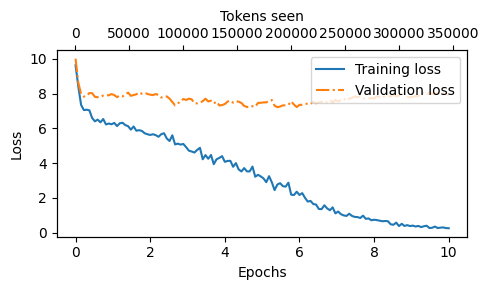

In [70]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Both the training and validation losses start to improve for the first epoch. However, the losses start to diverge past the second epoch.

This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfitting to the training data.

This memorization is expected since we are working with a very, very small training dataset and training the model for multiple epochs.

Usually, it's common to train a model on a much, much larger dataset for only one epoch.

# Temprature Scaling

Previously, inside the generate_text_simple function, we always sampled the token with the highest probability as the next token using torch.argmax, also known as greedy decoding.

To generate text with more variety, we can replace the argmax with a function that samples from a probability distribution (here, the probability scores the LLM generates for each vocabulary entry at each token generation step).

To illustrate the probabilistic sampling with a concrete example, let's briefly discuss the next-token generation process using a very small vocabulary for illustration purposes:

In [71]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

Next, assume the LLM is given the start context "every effort moves you" and generates the following next-token logits:

In [72]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

next_token_logits2 = next_token_logits/0.1

next_token_logits3 = next_token_logits/5

As discussed in the previous chapter, inside the generate_text_simple, we convert the logits into probabilities via the softmax function and obtain the token ID corresponding the generated token via the argmax function, which we can then map back into text via the inverse vocabulary:

In [73]:
probas = torch.softmax(next_token_logits2, dim=0)

print(probas)

tensor([    0.0000,     0.0000,     0.0000,     0.9910,     0.0000,     0.0000,
            0.0000,     0.0090,     0.0000])


In [74]:
probas = torch.softmax(next_token_logits3, dim=0)

print(probas)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [75]:
probas = torch.softmax(next_token_logits, dim=0)

print(probas)

next_token_id = torch.argmax(probas).item()

print(next_token_id)

print(inverse_vocab[next_token_id])

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])
3
forward


To implement a probabilistic sampling process, we can now replace the argmax with the multinomial function in PyTorch:

In [76]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


The printed output is "forward" just like before. What happened? The multinomial function samples the next token proportional to its probability score.

In other words, "forward" is still the most likely token and will be selected by multinomial most of the time but not all the time.

To illustrate this, let's implement a function that repeats this sampling 1000 times:

In [77]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


As we can see based on the output, the word "forward" is sampled most of the time (582 out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also be sampled some of the time.

This means that if we replaced the argmax function with the multinomial function inside the generate_and_print_sample function, the LLM would sometimes generate texts such as "every effort moves you toward", "every effort moves you inches", and "every effort moves you closer" instead of "every effort moves you forward".

We can further control the distribution and selection process via a concept called temperature scaling, where temperature scaling is just a fancy description for dividing the logits by a number greater than 0:

Temperatures greater than 1 result in more uniformly distributed token probabilities, and Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions.

Let's illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:

In [78]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

##Multinomial

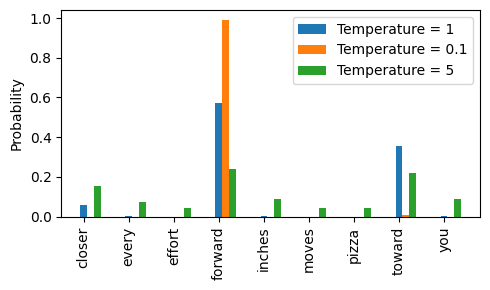

In [79]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

A temperature of 1 divides the logits by 1 before passing them to the softmax function to compute the probability scores.

In other words, using a temperature of 1 is the same as not using any temperature scaling.

In this case, the tokens are selected with a probability equal to the original softmax probability scores via the multinomial sampling function in PyTorch.

Applying very small temperatures, such as 0.1, will result in sharper distributions such that the behavior of the multinomial function selects the most likely token (here: "forward") almost 100% of the time, approaching the behavior of the argmax function.

Vice versa, a temperature of 5 results in a more uniform distribution where other tokens are selected more often.

This can add more variety to the generated texts but also more often results in nonsensical text.

For example, using the temperature of 5 results in texts such as "every effort moves you pizza" about 4% of the time.

# DECODING STRATEGY 2: Top-k sampling

In the previous section, we implemented a probabilistic sampling approach coupled with temperature scaling to increase the diversity of the outputs.

We saw that higher temperature values result in more uniformly distributed next-token probabilities, which result in more diverse outputs as it reduces the likelihood of the model repeatedly selecting the most probable token.

This method allows for exploring less likely but potentially more interesting and creative paths in the generation process.

However, One downside of this approach is that it sometimes leads to grammatically incorrect or completely nonsensical outputs such as "every effort moves you pizza".

In this section, we introduce another concept called top-k sampling, which, when combined with probabilistic sampling and temperature scaling, can improve the text generation results.

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process by masking their probability scores.

In [80]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Subsequently, we apply PyTorch's where function to set the logit values of tokens that are below the lowest logit value within our top-3 selection to negative infinity (-inf).

In [81]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [82]:
# Lastly, let's apply the softmax function to turn these into next-token probabilities:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Merge Temperature Scaling and Top-k sampling

We can now apply the temperature scaling and multinomial function for probabilistic sampling introduced in the previous section to select the next token among these 3 nonzero probability scores to generate the next token. We do this in the next section by modifying the text generation function.

The previous two subsections introduced two concepts to increase the diversity of LLMgenerated text: temperature sampling and top-k sampling. In this section, we combine and add these concepts to modify the generate_simple function we used to generate text via the LLM earlier, creating a new generate function:

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling

Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified

In [83]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [84]:
# Ensure the model is on the GPU
model = model.to("cuda")

# Set the seed for reproducibility
torch.manual_seed(123)

# Generate text
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to("cuda"),  # Move input to GPU
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

# Decode and print the output text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you if all men of all th'n views and knows whose soul is piety


# FINETUNING FOR CLASSIFICATION

In [85]:
# DOWNLOAD DATASET

import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


After executing the preceding code, the dataset is saved as a tab-separated text file, SMSSpamCollection.tsv, in the sms_spam_collection folder.

We can load it into a pandas DataFrame as follows:

In [86]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [87]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


For simplicity, and because we prefer a small dataset for educational purposes anyway (it will make it possible to finetune the LLM faster), we subsample (undersample) the dataset so that it contains 747 instances from each class

In [88]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


After executing the previous code to balance the dataset, we can see that we now have equal amounts of spam and non-spam messages:

Next, we convert the "string" class labels "ham" and "spam" into integer class labels 0 and 1, respectively:

In [89]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

This process is similar to converting text into token IDs.

However, instead of using the GPT vocabulary, which consists of more than 50,000 words, we are dealing with just two token IDs: 0 and 1.

In [90]:
# We create a random_split function to split the dataset into three parts: 70% for training, 10% for validation, and 20% for testing.

def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder


In [91]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [92]:
# Additionally, we save the dataset as CSV (comma-separated value) files, which we can reuse later:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### CREATING DATALOADERS